In [92]:
from sys import path
path.append("../")
%matplotlib inline

### Read in the data

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('data.csv')
df.head()

X            Y   LandUse   Latitude  Longitude
0  618522.8899  6218452.029  Forestry -34.168155 -55.714061
1  649042.3861  6199719.402  Forestry -34.333113 -55.379803
2  655993.6095  6200009.045  Forestry -34.329479 -55.304319
3  656440.0958  6200236.666  Forestry -34.327360 -55.299509
4  656825.7859  6199755.161  Forestry -34.331642 -55.295231

### See Label Distribution

In [3]:
df.groupby("LandUse").size()

LandUse
Forestry              6
Fruittrees            3
Nativeforest         13
Naturalgrassland    175
Other                 8
Prairie              59
Stubble               9
Summercrops         150
Water                 1
dtype: int64

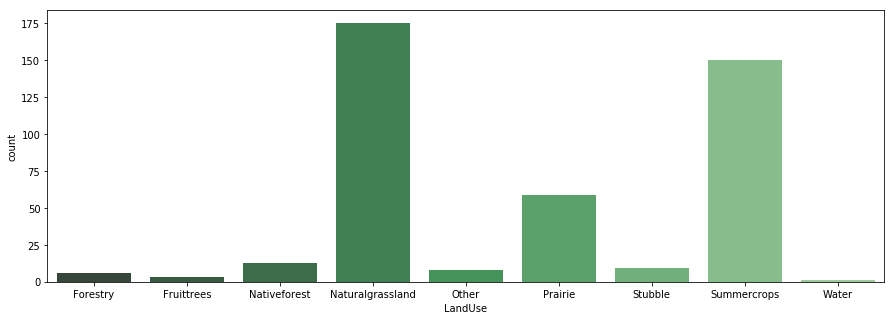

In [91]:
from matplotlib import pyplot
import seaborn as sns

fig, ax = pyplot.subplots(figsize=(15,5))
sns.countplot(x="LandUse",data=df, palette="Greens_d");

### Classification Re-org

The following classes do not have enough training examples to guarantee high enough variance:  

- `Forestry`
- `Fruittrees`
- `Nativeforest`
- `Stubble`
- `Water`

My suggestion is reducing features/label-set to the following:  

- `Natural Grassland`  
- `Summercrops`  
- `Prairie`  
  
as well as a grouping of `Forestry`, `FruitTrees`, and `Native Forest` under:  

- `Forest`  

then grouping other labels under a class called:

- `Misc`


### Rebuild Classes

In [5]:
def combine_classes_on_dataframe(_df, classes = [], combine_to = "default", column_name = "LandUse"):
    df_new = df.copy()  
    df_new[column_name].update(df_new[column_name].map(lambda x: combine_to if x in classes else x ))
    return df_new

In [6]:
df_new = df.copy()  
df_new['LandUse'].update(df_new['LandUse'].map(lambda x: "Forest" if x in ["Forestry","Fruittrees","Nativeforest"] else x ))
df_new['LandUse'].update(df_new['LandUse'].map(lambda x: "Misc" if x  not in ["Forest","Prairie","Summercrops","Naturalgrassland"] else x ))

In [7]:
df_new.groupby("LandUse").size()

LandUse
Forest               22
Misc                 18
Naturalgrassland    175
Prairie              59
Summercrops         150
dtype: int64

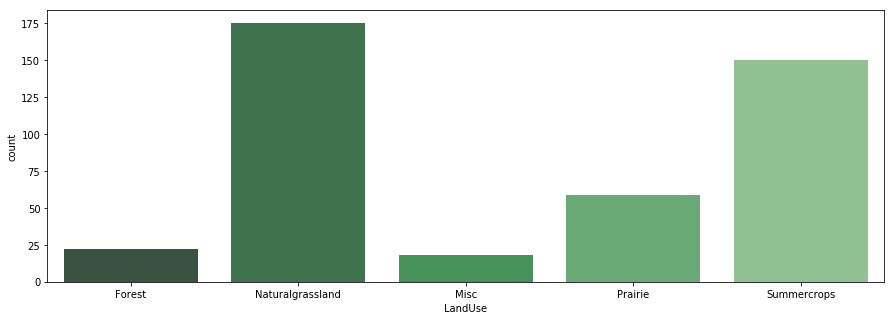

In [8]:
fig, ax = pyplot.subplots(figsize=(15,5))
sns.countplot(x="LandUse",data=df_new, palette="Greens_d");

### Import Training Data

In [9]:
import datacube
dc = datacube.Datacube(config = "/home/localuser/.datacube.conf")

>**LIsting products with 'uruguay' in its name**

In [10]:
dc.list_products()[dc.list_products()['name'].str.contains("uruguay")]

name                                        description  lon  \
id                                                                              
40  ls8_lasrc_uruguay  Landsat 8 USGS Collection 1 Higher Level SR sc...  NaN   

    sat_path instrument  lat   platform  time  format  sat_row  gsi  \
id                                                                    
40       NaN   OLI_TIRS  NaN  LANDSAT_8  None  NetCDF      NaN  NaN   

   product_type  orbit        crs                               resolution  \
id                                                                           
40        LaSRC    NaN  EPSG:4326  [-0.000269494585236, 0.000269494585236]   

                           tile_size     spatial_dimensions  
id                                                           
40  [0.943231048326, 0.943231048326]  (latitude, longitude)

>**Load the data**

In [11]:
params = dict(platform = 'LANDSAT_8',
              product   = 'ls8_lasrc_uruguay',
              latitude = (-34.44988376, -34.096445),
              longitude = (-56.29119062, -55.24653668),
              measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'pixel_qa'])    

In [12]:
dataset = dc.load(**params)

> **Composite Data**

In [26]:
import numpy as np
import datetime 
from utils.data_cube_utilities.dc_mosaic import ls8_unpack_qa
from utils.data_cube_utilities.dc_mosaic import create_median_mosaic

def compress_on_time(_ds, date_range):
    subset = _ds.sel(time = slice(*date_range)) # select a smaller date-range 
    
    water_mask = ls8_unpack_qa(subset.pixel_qa, cover_type = "water")
    clear_mask = ls8_unpack_qa(subset.pixel_qa, cover_type = "clear")
    clean_mask = np.logical_or(water_mask, clear_mask)
    
    return create_median_mosaic(subset, clean_mask = clean_mask)

In [27]:
dataset_composite = compress_on_time(dataset, ('2016-01-01', '2017-01-01'))

> **Normalization**

In [28]:
dataset_composite = dataset_composite.drop('pixel_qa')

In [29]:
dataset_composite_normalalized = dataset_composite.copy(deep = True)
for band_name in dataset_composite_normalalized.data_vars:  
    arr = dataset_composite_normalalized[band_name].values
    arr[arr > 10000] = 10000
    arr[arr < 0] = 10000

In [30]:
dataset_composite_normalalized = dataset_composite_normalalized  * (1/10000)

In [31]:
dataset_composite_normalalized

<xarray.Dataset>
Dimensions:    (latitude: 1313, longitude: 3877)
Coordinates:
  * latitude   (latitude) float64 -34.1 -34.1 -34.1 -34.1 -34.1 -34.1 -34.1 ...
  * longitude  (longitude) float64 -56.29 -56.29 -56.29 -56.29 -56.29 -56.29 ...
Data variables:
    red        (latitude, longitude) float64 0.062 0.0638 0.0659 0.0678 ...
    green      (latitude, longitude) float64 0.071 0.0714 0.0721 0.0739 ...
    blue       (latitude, longitude) float64 0.0428 0.0434 0.0443 0.0456 ...
    nir        (latitude, longitude) float64 0.2962 0.29 0.2894 0.2866 ...
    swir1      (latitude, longitude) float64 0.2563 0.2622 0.2654 0.2709 ...
    swir2      (latitude, longitude) float64 0.1444 0.1507 0.1532 0.1529 ...

## Feature Engineering

The default features for a Landsat based classifier are:
- `red`
- `green`
- `blue`
- `nir`
- `swir1`
- `swir1`  

High order relationships between these features can also be used inputs to a random forest classifier. The following indices are already used in Landsat analysis and correlate with the existence of several land classes like water, chlorophyll, sediment/top-soil:  

- `NDVI`
- `NDWI`
- `NDBI`
- `SCI`
- `CCCI`
- `CVI`
- `PNDVI`

These are not the best features to include but are easy to source. The code below should serve as a template of adding new features to the random forest feature classifier.

<br>

In [32]:
import matplotlib.pyplot as plt

def plot_xarray(data_array):
    fig = plt.figure(figsize = (15,5))
    plt.axis('equal')
    data_array.plot()

> **NDVI**

In [33]:
def NDVI(dataset):
    return (dataset.nir - dataset.red)/(dataset.nir + dataset.red).rename("NDVI")

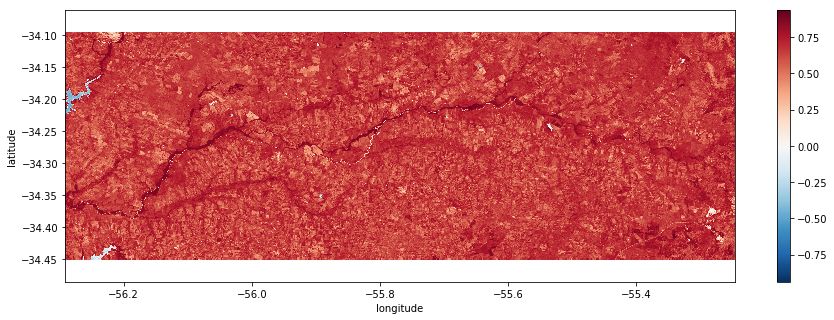

In [34]:
plot_xarray( NDVI(dataset_composite) )

> **NBR**

In [35]:
def NBR(dataset):
    return ((dataset.nir - dataset.swir2) / (dataset.swir2 + dataset.nir)).rename("NBR")

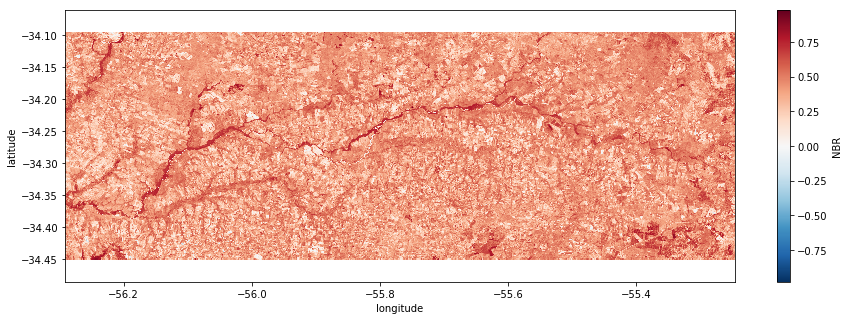

In [36]:
plot_xarray(  NBR(dataset_composite)  )

> **NDBI**

In [37]:
def NDBI(dataset):
    return (( dataset.swir1 - dataset.nir ) / (dataset.swir1 + dataset.nir)).rename("NDBI")

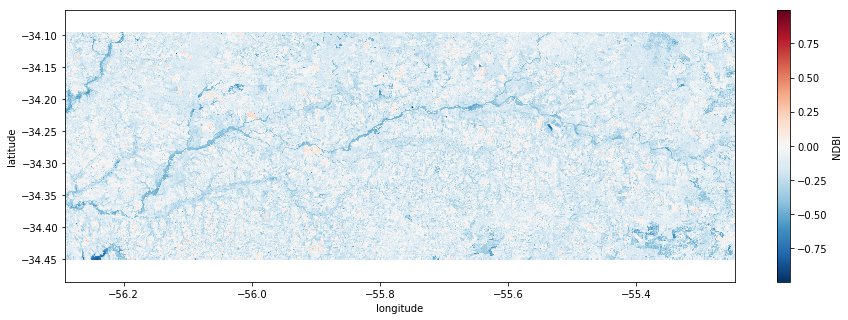

In [38]:
plot_xarray( NDBI(dataset_composite) ) 

>**NDWI**

In [39]:
def NDWI_1(dataset):
    return (dataset.nir - dataset.swir1)/(dataset.nir + dataset.swir1).rename("NDWI_1")

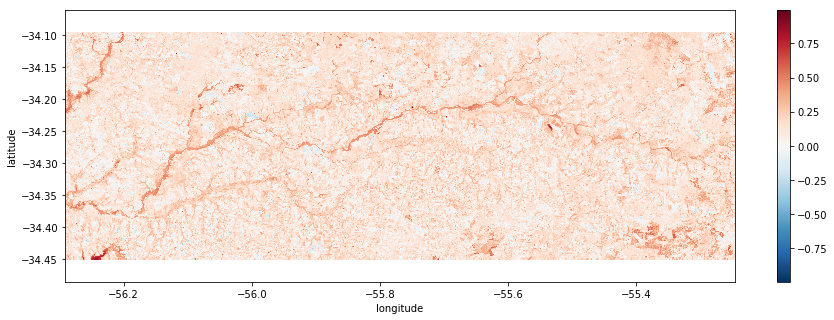

In [40]:
plot_xarray( NDWI_1(dataset_composite) ) 

In [41]:
def NDWI_2(dataset):
    return (dataset.green - dataset.nir)/(dataset.green + dataset.nir).rename("NDWI_2")

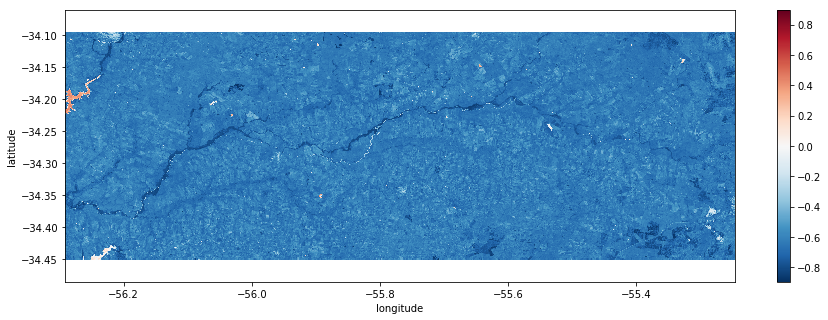

In [42]:
plot_xarray( NDWI_2(dataset_composite) )

>**SCI**

In [43]:
def SCI(dataset):
    return ((dataset.swir1 - dataset.nir)/(dataset.swir1 + dataset.nir)).rename("SCI")

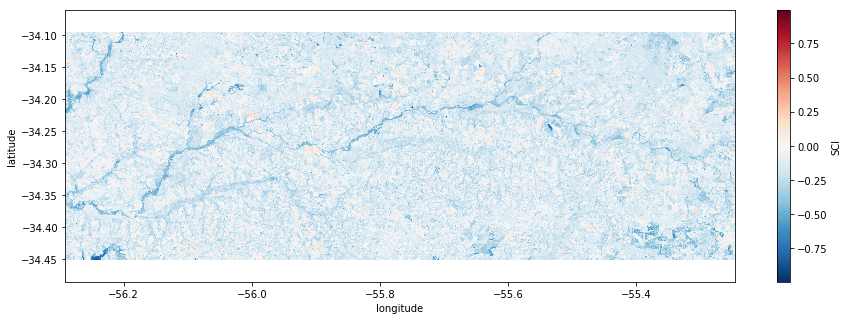

In [44]:
plot_xarray( SCI(dataset_composite) )

> **NBR2**

In [45]:
def NBR2(dataset):
    return (dataset.swir1 - dataset.swir2)/(dataset.swir1 + dataset.swir2)

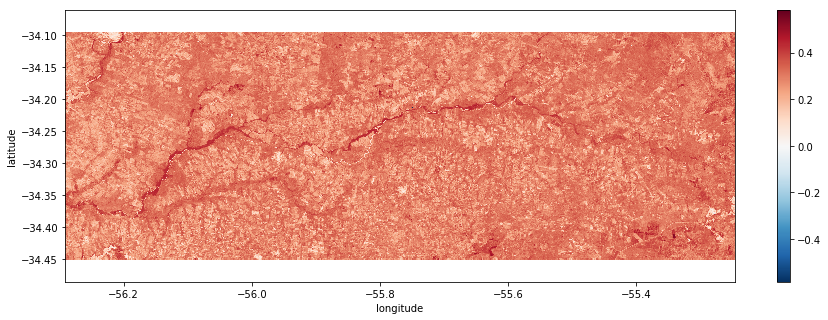

In [46]:
plot_xarray( NBR2(dataset_composite) )

> **CCCI**  

In [47]:
def CCCI(dataset):
    return ((dataset.nir - dataset.red)/(dataset.nir + dataset.red)).rename("CCCI")

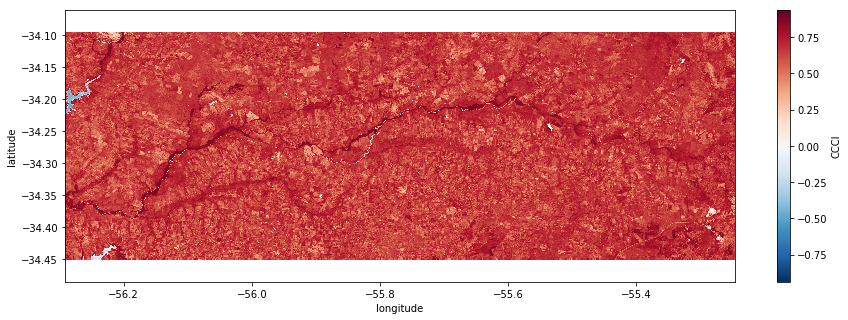

In [48]:
plot_xarray( CCCI(dataset_composite) )

> **CVI**

In [49]:
def CVI(dataset):
    return (dataset.nir * (dataset.red / (dataset.green * dataset.green))).rename("CVI")

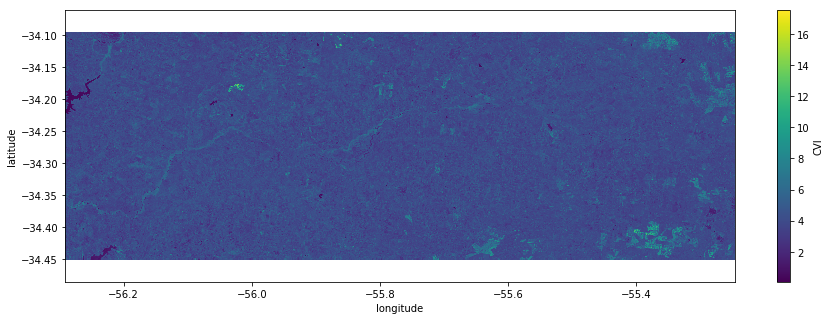

In [50]:
plot_xarray( CVI(dataset_composite) )

> **PNDVI**

In [51]:
def PNDVI(dataset):
    
    nir = dataset.nir
    green = dataset.green
    blue = dataset.blue
    red = dataset.red
    
    return ((nir - (green + red + blue))/(nir + (green + red + blue))).rename("PNDVI")

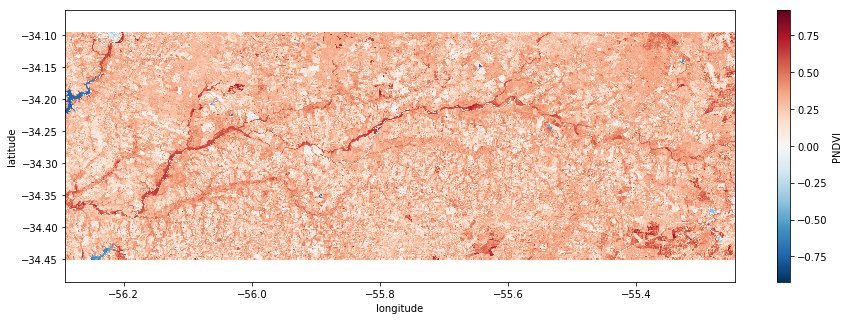

In [52]:
plot_xarray( PNDVI(dataset_composite) )

> **Normalize and merge features into a single data-set**

In [53]:
import xarray as xr  
def normalize( da :xr.DataArray) -> xr.Dataset:
    return (da-da.min())/(da.max() - da.min())

In [54]:
pndvi  = PNDVI(  dataset_composite).to_dataset(name = "PNDVI")
ndbi   = NDBI(   dataset_composite).to_dataset(name = "NDBI")
nbr    = NBR(    dataset_composite).to_dataset(name = "NBR")
nbr2   = NBR2(   dataset_composite).to_dataset(name = "NBR2")
cvi    = CVI(    dataset_composite).to_dataset(name = "CVI")
ccci   = CCCI(   dataset_composite).to_dataset(name = "CCCI")
sci    = SCI(    dataset_composite).to_dataset(name = "SCI")
ndwi1  = NDWI_1( dataset_composite).to_dataset(name = "NDWI1")
ndwi2  = NDWI_2( dataset_composite).to_dataset(name = "NDWI2")
ndvi   = NDVI(   dataset_composite).to_dataset(name = "NDVI")

features = xr.merge([normalize(pndvi),
                     normalize(cvi),
                     normalize(nbr),
                     normalize(nbr2),
                     normalize(ndbi),
                     normalize(ccci),
                     normalize(sci),
                     normalize(ndwi1),
                     normalize(ndwi2),
                     normalize(ndvi),
                     dataset_composite_normalalized]
                   )

In [55]:
features

<xarray.Dataset>
Dimensions:    (latitude: 1313, longitude: 3877)
Coordinates:
  * latitude   (latitude) float64 -34.1 -34.1 -34.1 -34.1 -34.1 -34.1 -34.1 ...
  * longitude  (longitude) float64 -56.29 -56.29 -56.29 -56.29 -56.29 -56.29 ...
Data variables:
    PNDVI      (latitude, longitude) float64 0.6843 0.6742 0.668 0.6578 ...
    CVI        (latitude, longitude) float64 0.2041 0.2033 0.2055 0.1992 ...
    NBR        (latitude, longitude) float64 0.5605 0.5408 0.535 0.5326 ...
    NBR2       (latitude, longitude) float64 0.7661 0.7579 0.7561 0.7653 ...
    NDBI       (latitude, longitude) float64 0.6049 0.6192 0.6239 0.6338 ...
    CCCI       (latitude, longitude) float64 0.834 0.8256 0.8195 0.8127 ...
    SCI        (latitude, longitude) float64 0.6049 0.6192 0.6239 0.6338 ...
    NDWI1      (latitude, longitude) float64 0.3951 0.3808 0.3761 0.3662 ...
    NDWI2      (latitude, longitude) float64 0.1653 0.1702 0.1724 0.1789 ...
    NDVI       (latitude, longitude) float64 0.834 0.8

<br>  
## Build Training Data set

This section involves formatting the data for random forest classifier training. The approach is not well polished and may un-necessarily complicate the process. 

In [56]:
landcover_names = list(df_new.groupby("LandUse").size().index)

In [57]:
training_dict = {name: [] for name in landcover_names}
training_dict

{'Forest': [],
 'Misc': [],
 'Naturalgrassland': [],
 'Prairie': [],
 'Summercrops': []}

In [58]:
pandas_rows = [x[1] for x in df_new.iterrows()]

In [59]:
# Example of first 2 elements
pandas_rows[:2]

[X                 618523
 Y            6.21845e+06
 LandUse           Forest
 Latitude        -34.1682
 Longitude       -55.7141
 Name: 0, dtype: object, X                 649042
 Y            6.19972e+06
 LandUse           Forest
 Latitude        -34.3331
 Longitude       -55.3798
 Name: 1, dtype: object]

In [60]:
def xarray_pixel_to_array(_dataset):
    return [float(_dataset[variable_name].values) for variable_name in _dataset.data_vars]

for point_data in pandas_rows:
    training_dict[point_data["LandUse"]].append(
        xarray_pixel_to_array(
            features.sel(latitude = point_data["Latitude"],
                         longitude = point_data["Longitude"],
                         method = 'nearest')))

In [61]:
data_list = []
target_list = []
ordered_class_names = []
for i, name in enumerate(training_dict.keys()):
    ordered_class_names.append(name)
    data_list += training_dict[name]
    target_list += [i]*len(training_dict[name])

<br>  
# k-fold cross validation split

In [62]:
percentage_split = .33
random_number_seed = 42

In [63]:
from sklearn.model_selection import train_test_split

in_train, in_test, out_train, out_test = train_test_split(data_list,
                                                          target_list,
                                                          test_size = percentage_split,
                                                          random_state = random_number_seed)

> **Examine training-data distribution**

(array([110.,   0., 110.,   0.,   0.,  38.,   0.,  13.,   0.,  13.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

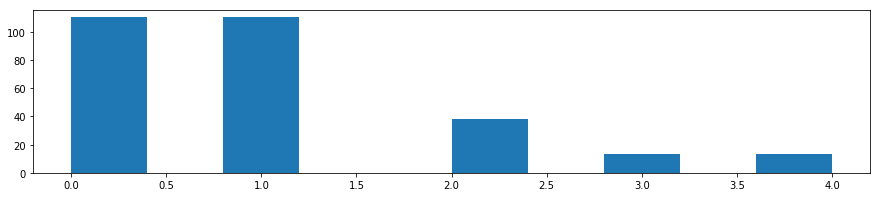

In [64]:
plt.figure(figsize = (15,3))
plt.hist(out_train)

> **Examine testing-data distribution**

(array([65.,  0., 40.,  0.,  0., 21.,  0.,  5.,  0.,  9.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

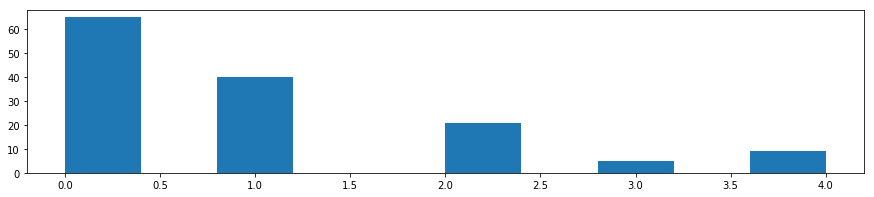

In [65]:
plt.figure(figsize = (15,3))
plt.hist(out_test)

<br>
# training a random forest classifier

In [66]:
from sklearn.ensemble import RandomForestClassifier

In [67]:
clf = RandomForestClassifier(max_depth=10,
                             n_estimators = 1000,
                             random_state=random_number_seed)

In [68]:
clf.fit(in_train, out_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [69]:
clf.score(in_test,
          out_test,
          sample_weight=None)

0.5857142857142857

### linear search for optimum depth

In [170]:
max_depth = 40
random_number_seed = 42

In [196]:
from time import time 

hyper_param_list = []
for i in range(2, max_depth):
    t1 = time()
    clf = RandomForestClassifier(max_depth=i,
                                 n_estimators = 1000,)
#                                  random_state=random_number_seed)
    clf.fit(in_train, out_train)
    t2 = time()
    hyper_param_list.append( [i,clf.score(in_test, out_test)])

In [197]:
x, y = zip(*hyper_param_list)

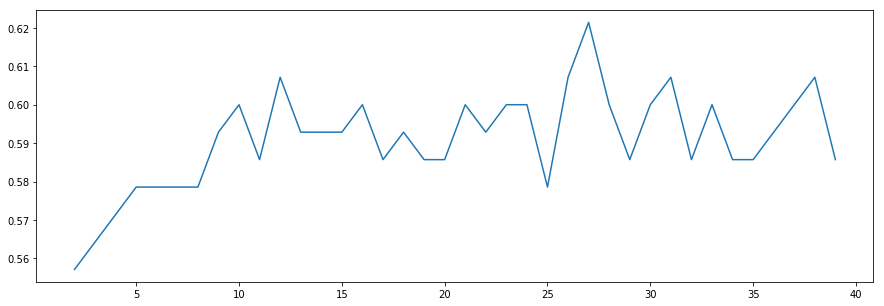

In [198]:
plt.figure(figsize = (15,5))
plt.plot(x,y)

In [199]:
max(hyper_param_list, key = lambda x: x[1])

[27, 0.6214285714285714]

# Validation  

> **Rebuild Model**

In [77]:
clf = RandomForestClassifier(max_depth=3,
                                 n_estimators = 1000,
                                 random_state=random_number_seed)

clf.fit(in_train, out_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

> **Confusion Matrix**

In [82]:
from sklearn.metrics import confusion_matrix
y_true = out_test
y_pred = clf.predict(in_test)

cm = confusion_matrix(y_true, y_pred)

In [83]:
cm

array([[49, 16,  0,  0,  0],
       [17, 23,  0,  0,  0],
       [10, 11,  0,  0,  0],
       [ 2,  3,  0,  0,  0],
       [ 1,  1,  0,  0,  7]])

> **Plotting the Confusion Matrix**

In [84]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    title = title if normalize == False else title + " (Normalized)"
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.125 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="red" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))

    plt.show()

<br>

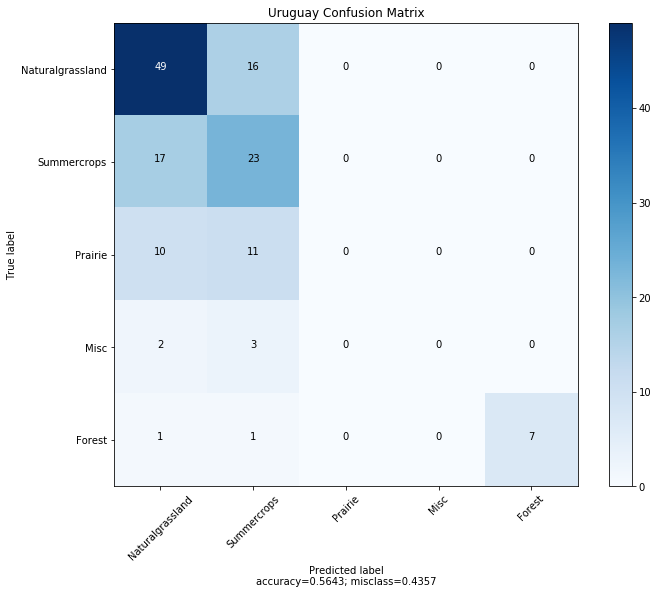

In [85]:
plot_confusion_matrix(cm, ordered_class_names, title='Uruguay Confusion Matrix', cmap=plt.cm.Blues, normalize=False)

<br>  

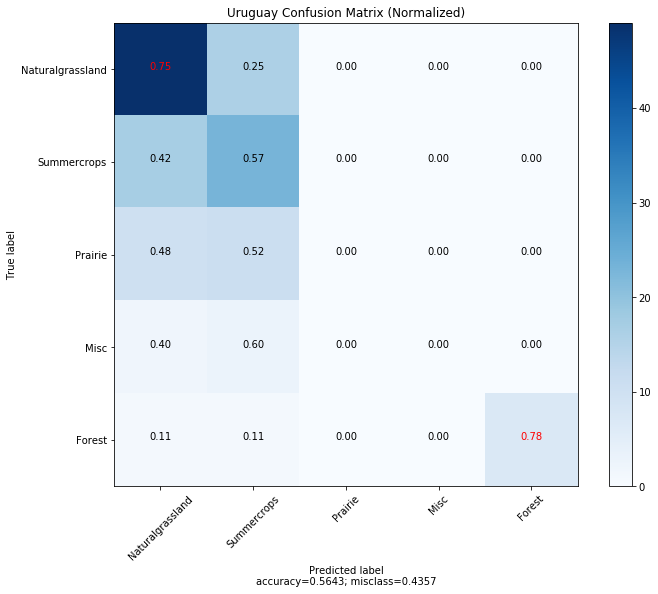

In [86]:
plot_confusion_matrix(cm, ordered_class_names, title='Uruguay Confusion Matrix', cmap=plt.cm.Blues, normalize=True)

<br>

> **Classifier Sensitivity **

In [87]:
def sensitivity(_cm, labels):
    _cm = np.array(_cm).astype(np.float64)
    totals = np.sum(_cm, axis = 0)
    diag_percentage = [cm[i][i]/total for i,total in enumerate(totals)]
    replace_nans = lambda x: 0 if np.isnan(x) else x  
    diag_percentage = map(replace_nans, diag_percentage)
    return { a:b for a,b in zip(labels, diag_percentage) }
    

<br>

In [88]:
sensitivity(cm, ordered_class_names)

/home/localuser/Datacube/datacube_env/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


{'Forest': 1.0,
 'Misc': 0,
 'Naturalgrassland': 0.620253164556962,
 'Prairie': 0,
 'Summercrops': 0.42592592592592593}

<br>  
> **Classifier Precision **

In [89]:
def precision(_cm, labels):
    _cm = np.array(_cm).astype(np.float64)
    totals = np.sum(_cm, axis = 1)
    diag_percentage = [cm[i][i]/total for i,total in enumerate(totals)]
    replace_nans = lambda x: 0 if np.isnan(x) else x  
    diag_percentage = map(replace_nans, diag_percentage)
    return { a:b for a,b in zip(labels, diag_percentage) }
    

<br>

In [90]:
precision(cm, ordered_class_names)

{'Forest': 0.7777777777777778,
 'Misc': 0.0,
 'Naturalgrassland': 0.7538461538461538,
 'Prairie': 0.0,
 'Summercrops': 0.575}

# Self contained class for land cover classification

In [99]:
import xarray as xr 
class XarrayRFC:
    def __register_feature_funcs(self, dataset:xr.Dataset):
        ndvi_lambda  = lambda ds:  ((ds.nir - ds.red)/(ds.nir + ds.red)).rename("NDVI")  
        nbr_lambda   = lambda ds:  ((ds.nir - ds.swir2) / (ds.swir2 + ds.nir)).rename("NBR")
        nbr2_lambda  = lambda ds:  ((ds.swir1 - ds.swir2)/(ds.swir1 + ds.swir2)).rename("NBR2")
        ndbi_lambda  = lambda ds:  (( ds.swir1 - ds.nir ) / (ds.swir1 + ds.nir)).rename("NDBI")
        ndwi1_lambda = lambda ds:  (ds.nir - ds.swir1)/(ds.nir + ds.swir1).rename("NDWI_1")
        ndwi2_lambda = lambda ds:  ((ds.green - ds.nir)/(ds.green + ds.nir)).rename("NDWI_2")
        sci_lambda   = lambda ds:  ((ds.swir1 - ds.nir)/(ds.swir1 + ds.nir)).rename("SCI")
        ccci_lambda  = lambda ds:  ((ds.nir - ds.red)/(ds.nir + ds.red)).rename("CCCI")    
        cvi_lambda   = lambda ds:  (ds.nir * (ds.red / (ds.green * ds.green))).rename("CVI")
        pndvi_lambda = lambda ds:  ((ds.nir - (ds.green + ds.red + ds.blue))/(ds.nir + (ds.green + ds.red + ds.blue))).rename("PNDVI")
        ## Ideas: fractional cover
        
        
    def __init__(self):
        self.ready_to_classify = False 
        
    def train(self, file_name):
        pass
        self.ready_to_classify = True
        
    def load(self, file_name):
        pass
        self.ready_to_classify = True

    def classifiy(self, dataset:xr.Dataset):
        if self.ready_to_classify == False:
            raise "Model was not trained. Cannot classify"

2